In [36]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

1(+6). Проверить, сбалансирован ли датасет (может быть, наблюдений одного класса слишком много?). Какие результаты покажет dummy classifier, который будет всем новым наблюдениям присваивать класс ham? Насколько плохо такое решение для задачи определения спама?<br />
Грубое решение - включить в training set только необходимое число наблюдений (примерно поровну spam и ham). <br />
Нормализовать тексты и обучить байесовскую модель (bag of words). Проверить, как влияют на результат:<br />

1) разная токенизация: в одном случае знаки препинания удалять, в другом — считать их токенами;<br />
2) лемматизация (отсутствие лемматизации, стемминг, лемматизация; инструменты можно использовать любые, например, nltk.stem);<br />
3) удаление стоп-слов, а также пороги минимальной и максимальной document frequency;<br />
4) векторизация документов (CountVectorizer vs. TfIdfVectorizer);<br />
5) что-нибудь ещё?<br />

При оценке классификатора обратите внимание на TP и FP.

Extra: ограничив количество наблюдений ham в обучающей выборке, мы игнорируем довольно много данных. 1) В цикле: случайно выбрать нужное число писем ham и сконструировать сбалансированную выборку, построить классификатор, оценить и записать результат; в итоге результаты усреднить. 2) поможет ли параметр class prior probability?

In [2]:
path = 'smsspamcollection/SMSSpamCollection'

messages = pd.read_csv(path, sep='\t',
                           names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Загрузили, посмотрели. Смотрим на классы

In [3]:
print(messages.groupby('label').describe())

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


Выборка очевидно несбалансирована по классам (~6:1). Соответственно, dummy-classifier, всегда присваивающий ярлык "ham", будет иметь accuracy ~86%, а confusion matrix будет выглядеть вот так:

In [4]:
d = {'clf_ham': pd.Series([4825, 747], index=['ham', 'spam']),
    'clf_spam': pd.Series([0, 0], index=['ham', 'spam'])}
pd.DataFrame(d)

,clf_ham,clf_spam
ham,4825,0
spam,747,0


Для задачи определения спама классификатор, который никогда не определяет спам, абсолютно бесполезен просто по определению.

In [ ]:
ham = messages.loc[messages['label']=='ham']
spam = messages.loc[messages['label']=='spam']

In [24]:
# и да, мне всё равно, что он работает только на существительных
lm = WordNetLemmatizer()
st = LancasterStemmer()

def nopunct(strin):
    res = [x.strip(string.punctuation) for x in strin.split()]
    return res

parameters = {'vect__stop_words': [None, 'english'],
              'vect__min_df': [1, 3],
              'vect__max_df': [1.0, 0.6], 
              'vect__tokenizer': [nopunct, word_tokenize],
              'vect__preprocessor': [None, lm.lemmatize, st.stem]}

In [43]:
shdata = []
paramset = []
for i in range(6):
    shard = pd.concat([ham.sample(n=747), spam]).sample(frac=1) # это я случайно выбираю строчки и перемешиваю
    print('Training for shard {}'.format(i))
    X_train, X_test, y_train, y_test = train_test_split(shard['message'], shard['label'])
    
    CV_clf = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()), 
                       ('clf', MultinomialNB()),])
    TI_clf = Pipeline([('vect', TfidfVectorizer()),
                       ('tfidf', TfidfTransformer()), 
                       ('clf', MultinomialNB()),])
    
    gs_cv = GridSearchCV(CV_clf, parameters)
    gs_ti = GridSearchCV(TI_clf, parameters)
    
    print('tuning with CountVectorizer...')
    gs_cv = gs_cv.fit(X_train, y_train)
    print('tuning with TfidfVectorizer...')
    gs_ti = gs_ti.fit(X_train, y_train)
    print('all fitted')
    
    paramset = gs_cv.cv_results_['params']
    
    print('Predicting...')
    praed_cv, praed_ti = gs_cv.predict(X_test), gs_ti.predict(X_test)
    
    shdata.append(gs_cv.cv_results_)
    shdata.append(gs_ti.cv_results_)
    print()
    
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for CV')
# plt.legend(loc="lower right")
# plt.show()

Training for shard 0
tuning with CountVectorizer...
tuning with TfidfVectorizer...
all fitted
Predicting...


NameError: name 'gs_tf' is not defined

In [28]:
len(shdata)

12

Ура, есть cv_results для всего. Теперь усреднять

In [30]:
paramset = shdata[0]['params']

In [33]:
cv = np.array([shdata[x]['mean_test_score'] for x in range(1, 6, 2)]).mean(axis=0)
tf = np.array([shdata[x]['mean_test_score'] for x in range(2, 7, 2)]).mean(axis=0)
cv

array([ 0.95091477,  0.95560018,  0.94042838,  0.9453369 ,  0.94578313,
        0.95069166,  0.94712182,  0.94823739,  0.95113788,  0.95560018,
        0.94042838,  0.9453369 ,  0.94087461,  0.94689871,  0.93105756,
        0.93663543,  0.93507363,  0.94065149,  0.93351183,  0.94109772,
        0.94065149,  0.94645248,  0.93038822,  0.93663543,  0.95091477,
        0.95560018,  0.94042838,  0.9453369 ,  0.94578313,  0.95069166,
        0.94712182,  0.94823739,  0.95113788,  0.95560018,  0.94042838,
        0.9453369 ,  0.94087461,  0.94689871,  0.93105756,  0.93663543,
        0.93507363,  0.94065149,  0.93351183,  0.94109772,  0.94065149,
        0.94645248,  0.93038822,  0.93663543])

In [37]:
paramset[0]

{'vect__max_df': 1.0,
 'vect__min_df': 1,
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.nopunct>}

<function matplotlib.pyplot.show>

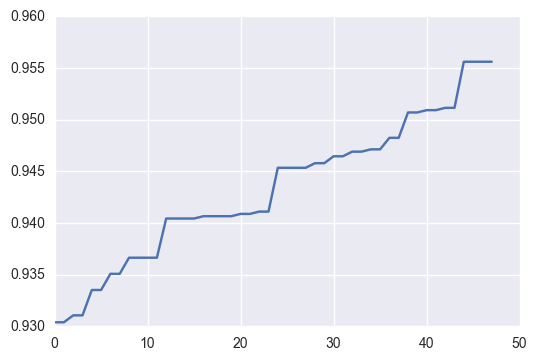

In [49]:
plt.plot(list(range(len(cv))), sorted(cv))
plt.show

2(+2). Сравнить результаты <br />
- байесовского классификатора, <br />
- решающего дерева <br />
- и RandomForest. <br />
Помимо стандартных метрик оценки качества модели, необходимо построить <br />
- learning curve, <br />
- ROC-curve, <br />
- classification report <br />
и интерпретировать эти результаты.

In [ ]:
tree = DecisionTreeClassifier(random_state=6)
vect = ??
treedata = []
for i in range(6):
    shard = pd.concat([ham.sample(n=747), spam]).sample(frac=1) # это я случайно выбираю строчки и перемешиваю
    # так как тут шесть выборок и кросс-валидация я не вижу особой необходимости делать отдельно тестовую выборку. 
    # К тому же это будет технически сложно с учётом прогонов разных векторайзеров, я лучше потом отдельно
    print('Training tree for shard {}'.format(i))
    X_train, X_test, y_train, y_test = train_test_split(shard['message'], shard['label'])
    vect = vect.fit(X_train)
    X_train = vect.transform(X_train)
    X_test = vect.transform(X_test)
    tree.fit(X_train, y_train)
    
    probas_ = gs_cv.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    print()

tree_means = np.array([treedata[x]['mean_test_score'] for x in range(1, 6, 2)]).mean(axis=0)

3(+2). А что, если в качестве предикторов брать не количество вхождений слов, а конструировать специальные признаки? Прежде всего, необходимо разделить таблицу на training set и test set в соотношении 80:20, test set не открывать до этапа оценки модели. С помощью pandas проверить, отличаются ли перечисленные ниже параметры (иможно придумать другие) для разных классов (spam/ham), и собрать матрицу признаков для обучения. Примеры признаков: длина сообщения, количество букв в ВЕРХНЕМ РЕГИСТРЕ, восклицательных знаков, цифр, запятых, каких-то конкретных слов (для этого можно построить частотный словарь по сообщениям каждого класса). Прокомментировать свой выбор. Векторизовать документы и построить классификатор. Оценить модель на проверочной выборке.